# Modeling

## Table of Contents:
* [Import Data, Packages, and Create Train Test Split](#first-bullet)
* [Multinomial Naive Bayes Model](#second-bullet)
    * [Multinomial NB Using CountVectorizer (CVEC)](#third-bullet)
    * [Multinomial NB Using TF-IDF](#fourth-bullet)
* [Logistic Regression (LR) Model](#five-bullet)
    * [LR Using CountVectorizer (CVEC)](#six-bullet)
    * [LR Using TF-IDF](#seven-bullet)
* [Random Forest (RF) Model](#eight-bullet)
    * [RF Using CountVectorizer (CVEC)](#nine-bullet)
    * [RF Using TF-IDF](#ten-bullet)
* [Tuning AdaBoost Model](#eleven-bullet)
    * [AdaBoost Using CountVectorizer (CVEC)](#twelve-bullet)
    * [AdaBoost Using TF-IDF](#thirteen-bullet)
* [Voting Classifier Model](#fourteen-bullet)
* [Evaluation Metrics](#fifteen-bullet)
* [Conclusion](#sixteen-bullet)

## Import Data, Packages, and Create Train Test Split <a class="anchor" id="first-bullet"></a>

In the prior notebooks ("1_import_data" and "2_eda"), we imported data from the canoeing and table tennis sub-reddits.
We determined that because 50% of the posts in our dataset are table tennis, in our classification models, 50% will serve as our baseline accuracy.  We will arbitrarily select table tennis as the positive for our models.  Because we have an equal
number of each class, it will not matter which class we use to calculate our baseline accuracy.  If we did not have this 
50/50 split, our baseline accuracy would be determined by the larger of the two.

In [409]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [145]:
## Import Data and Packagesimport pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

First, we will import our csvs containing the post data into two separate data frames.  Next, we will combine the two into 
one dataframe.  Our classification models need a numeric y-value, so we will turn the sub-reddit name field into an int
field, by assigning 0 to canoe and 1 to table tennis.  For our modeling, the post tile will serve as our x-value.

In [3]:
# import data
import pandas as pd
import numpy as np
tennis_df = pd.read_csv('./table_tennis_data.csv')
canoe_df = pd.read_csv('canoe_data.csv')

In [4]:
full_df = pd.concat([tennis_df, canoe_df], axis=0)

In [5]:
full_df = full_df.reset_index(drop=True)

In [6]:
full_df = full_df.drop(['Unnamed: 0'], axis=1)

In [7]:
# Binarize label column
full_df["post_sub"] = full_df["post_sub"].map({"canoeing":0,"tabletennis":1})

In [8]:
X = full_df['post_title'] # x needsto be a pd.arry / pd.series when feeding into a CountVectorizer
y = full_df['post_sub']

Using the X and y values that we created above, we will create training and test data sets to be used by the models that we 
create.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y) # maintain % of target classes

We will now run a variety of classification models to predict which sub-reddit a post title belongs to.  Because our goal is 
to predict as many posts correct as we can, we don't care if we get more table tennis or more canoeing posts.  If we had a 
preference to get more of one sub-reddit's posts correct, we would evaluate our models using specificity or sensitivity.
We will use accuracy as our evaluation metric, and judge all of the models we run on this metric.

In order to find the model with the highest accuracy, we will run five types of classification models: multinomial Naive Bayes,
logistic regression, Random Forest, runing AdaBoost, and Voting Classification.  We will try using two types of feature extraction tools for each model; Count Vectorizer and TF-IDF.

Our NLP models can't work with our unstructured X-values as they currently exist.  To implement our models, we will need to 
perform feature extraction to create a numeric X matrix.  Both of the feature extraction techniques will give us the ability
to run bag-of-words models.  This will represent our data (post title) as a set of the frequency of the words in a post title,
and will ignore grammer, word order, and sentence structre.

CVEC will give us the raw counts of each word in the set of post titles.  TF-IDF will give us an idea of the differences between the sub-reddits by weighting the popularity of words.  Words that appear commonly in many posts will be de-valued, and words that appear less frequently will be valued higher.

## Multinomal Naive Bayes Models <a class="anchor" id="second-bullet"></a>

The first model we will run will be our Naive Bayes model.  Using Bayes theorem, Naive Bayes classification models are commonly used in NLP classification problems.  The model assumes that each of the words in the text are independent.  Because the model typically performs well on test data in NLP problems, we are willing to make this assumption.  For our model, we will use the multinomial Naive Bayes model because the columns of X are integer counts.  If we had other data types, we would use either Bernoulli or Gaussian Naive Bayes models.

### Pipeline - CVEC + Multinomial NB <a class="anchor" id="third-bullet"></a>

As discussed above, we will run each of our models two ways; once using the CVEC and once using TF-IDF.  To run our models, we will set up a pipeline to run the vectorizer and the modeling one step.  We will also be using GridSearchCV in order to tune the hyperparameters of both the vectorizer and the model.  Finally, we will fit and score our models.

In [182]:
mb_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()), # or tvec
    ('mb', MultinomialNB())
    
])

For Naive Bayes, we will not set any parameters.  We will only be setting parameters for the CVEC.  Each of these parameters is set below and contains a comment on what is being set.

GridSearchCV will run through all of the possible combinations of parameters we have inputted.

We have also set up a cross validation of three, meaning we will split the data and run the model multiple times, giving us an average of multiple runs.

In [206]:
# Tune GridSearchCV
mb_cvec_pipe_params = {
    'cvec__stop_words' : [None, 'english'],  # if English, remove a list of common words from our dataset
    'cvec__decode_error' : ['ignore']  ,         # Either ignore or replace decoding errors ['ignore', 'replace'],
    'cvec__strip_accents': ['ascii']  ,          # How to deal with accents, either: ['ascii', 'unicode', None],
    'cvec__analyzer':['word']       ,            # How CVEC will create columns, either by word or character ['word', 'char', 'char_wb'] ,
    'cvec__max_features': [1250, 1300, 1350, 1400], # How many features to create in the matrix.
    'cvec__max_df' : [.1, .15, .2, .25], #ignore terms that occur in more than the indicated portion of documents
    'cvec__min_df' : [0, .05, .01], # ignore terms that occur in fewer than the indicated portion of documents
    'cvec__ngram_range' : [(1,1), (1, 2)] # create terms using either one or two word combinations
}
mb_cvec_gs = GridSearchCV(mb_cvec_pipe, param_grid=mb_cvec_pipe_params, cv=3, n_jobs=-1)
mb_cvec_gs.fit(X_train,y_train);

In [207]:
mb_cvec_gs.best_score_

0.9124452782989368

Below are the best parameters from the grid search that we ran above.

In [208]:
mb_cvec_gs.best_params_

{'cvec__analyzer': 'word',
 'cvec__decode_error': 'ignore',
 'cvec__max_df': 0.2,
 'cvec__max_features': 1300,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'cvec__strip_accents': 'ascii'}

In [209]:
# Train score
mb_cvec_gs.score(X_train, y_train)

0.9480925578486554

In [210]:
# Test score
mb_cvec_gs.score(X_test, y_test)

0.897003745318352

Our best Naive Bayes model, using CVEC, had an accuracy score on .95 on the training set and .90 on the test set.  We will compare the test accuracy score to the results of the other models to determine which model we should use.

### Pipeline - TF IDF + Multinomial NB <a class="anchor" id="fourth-bullet"></a>

Next, we will proceed with building our Naive bayes model using the TF-IDF (as described above).  We will use the same steps as we used for the CVEC Naive Bayes model.  TF-IDF will take in the same hyperparameters as we set for CVEC.

In [211]:
mb_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()), # or tvec
    ('mb', MultinomialNB())
    
])

In [219]:
# Tune GridSearchCV
mb_tvec_pipe_params = {
    'tvec__stop_words' : [None, 'english'],
    'tvec__decode_error' : ['ignore']  ,         
    'tvec__strip_accents': ['ascii']  ,          
    'tvec__analyzer':['word']       ,           
    'tvec__max_features': [    2000, 2250, 2500], 
    'tvec__max_df' : [.1, .15, .2, .25],
    'tvec__min_df' : [0, .05, .01],
    'tvec__ngram_range' : [(1,1), (1, 2)] 
}
mb_tvec_gs = GridSearchCV(mb_tvec_pipe, param_grid=mb_tvec_pipe_params, cv=3, n_jobs=-1)
mb_tvec_gs.fit(X_train,y_train);

In [220]:
mb_tvec_gs.best_score_

0.9161976235146967

In [221]:
mb_tvec_gs.best_params_

{'tvec__analyzer': 'word',
 'tvec__decode_error': 'ignore',
 'tvec__max_df': 0.2,
 'tvec__max_features': 2250,
 'tvec__min_df': 0,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english',
 'tvec__strip_accents': 'ascii'}

In [222]:
# Train score
mb_tvec_gs.score(X_train, y_train)

0.9806128830519074

In [223]:
# Test score
mb_tvec_gs.score(X_test, y_test)

0.9250936329588015

Using TF-IDF, our multinomial Naive Bayes model gave us an accuracy score of .98 on our training set and .93 on our test set.  Although the model is overfit (indicating high variance), we are only concerned with the results of our test data set.  Again, we will be comparing the test accuracy scores of all our models at the end of this notebook.

## Logistic Regression (LR) Models <a class="anchor" id="five-bullet"></a>

Logistic Regressions assumes that X1 - Xn are linearly realted to the log odds that y=1, that all of the errors are independent of one another, that the distribution of errors follows the Bernoulli distribution, adn that all of the independent variables are independent of one another.

Like with our multinomial Naive Bayes model, we cannot say that that independent varaibles are independent of one another.  THe words in the post titles almost certainly have a relationship to one another.  However, we will disregard this and see how the model performs.  

Like with MB Naive Bayes, we will test the model out using both CVEC and TF-IDF.

### Pipeline - CVEC + LR <a class="anchor" id="six-bullet"></a>

In [224]:
lr_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()), # or tvec
    ('lr', LogisticRegression())
    
])

In [237]:
# Tune GridSearchCV
lr_cvec_pipe_params = {
    'cvec__stop_words' : [None, 'english'],
    'cvec__decode_error' : ['ignore']  ,         
    'cvec__strip_accents': ['ascii']  ,         
    'cvec__analyzer':['word']       ,            
    'cvec__max_features': [    1500, 1750, 2000], 
    'cvec__max_df' : [.1, .15, .2, .25],
    'cvec__min_df' : [0, .05, .01],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'lr__penalty' : ['l1', 'l2']
}
lr_cvec_gs = GridSearchCV(lr_cvec_pipe, param_grid=lr_cvec_pipe_params, cv=3, n_jobs = 1)
lr_cvec_gs.fit(X_train,y_train);

C:\Users\phill\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\phill\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [238]:
lr_cvec_gs.best_score_

0.9043151969981238

In [239]:
lr_cvec_gs.best_params_

{'cvec__analyzer': 'word',
 'cvec__decode_error': 'ignore',
 'cvec__max_df': 0.25,
 'cvec__max_features': 1750,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'cvec__strip_accents': 'ascii',
 'lr__penalty': 'l2'}

In [240]:
# Train score
lr_cvec_gs.score(X_train, y_train)

0.9856160100062539

In [241]:
# Test score
lr_cvec_gs.score(X_test, y_test)

0.900749063670412

Our LR model using CVEC gave us a training set accuracy of .99 and a test accuracy of .90.

### Pipeline - TF IDF + LR <a class="anchor" id="seven-bullet"></a>

In [242]:
lr_tfidf_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('lr', LogisticRegression())
    
])

In [271]:
# Tune GridSearchCV
lr_tfidf_pipe_params = {
    'tvec__stop_words' : [None, 'english'],
    'tvec__decode_error' : ['ignore']  ,         
    'tvec__strip_accents': ['ascii']  ,          
    'tvec__analyzer':['word']       ,            
    'tvec__max_features': [    2000, 2250, 2500], 
    'tvec__max_df' : [.1, .15, .2, .25],
    'tvec__min_df' : [0, .05, .01],
    'tvec__ngram_range' : [(1,1), (1, 2)],
    'lr__penalty' : ['l1', 'l2']

}
lr_tfidf_gs = GridSearchCV(lr_tfidf_pipe, param_grid=lr_tfidf_pipe_params, cv=3, n_jobs=-1)
lr_tfidf_gs.fit(X_train,y_train);

C:\Users\phill\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [272]:
lr_tfidf_gs.best_score_

0.9155722326454033

In [273]:
lr_tfidf_gs.best_params_

{'lr__penalty': 'l2',
 'tvec__analyzer': 'word',
 'tvec__decode_error': 'ignore',
 'tvec__max_df': 0.2,
 'tvec__max_features': 2250,
 'tvec__min_df': 0,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english',
 'tvec__strip_accents': 'ascii'}

In [274]:
# Train score
lr_tfidf_gs.score(X_train, y_train)

0.9831144465290806

In [275]:
# Test score
lr_tfidf_gs.score(X_test, y_test)

0.9288389513108615

Our LR model using TF-IDF gave us a training accuracy of .98 and a test accuracy of .93.

## Random Forest (RF) Models <a class="anchor" id="eight-bullet"></a>

Next, we will test out the random forest model.  Random forest takes a classic decision tree, and adds in bootstrapping (sampling of X rows with replacement) and randomized feature selection.  Based on the 'n_features' hyperparameter we will set in the GridSearch, we will create multiple trees.  Using the 'max_depth' hyperparameter, we will set the number of features that will be considered in our trees.  Random forest models generally have lower variance than either classic decision trees or bagged decision trees.  Since we saw high variance in our Naive Bayes and logistic regression models, a random forest model may be a good option for our data.

### Pipeline - CVEC  + RF  <a class="anchor" id="nine-bullet"></a>

In [276]:
rf_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()), # or tvec
    ('rf', RandomForestClassifier())
    
])

In [288]:
%%time
# Tune GridSearchCV
rf_cvec_pipe_params = {
    'cvec__stop_words' : [None, 'english'],
    'cvec__decode_error' : ['ignore']  ,         
    'cvec__strip_accents': ['ascii']  ,         
    'cvec__analyzer':['word']       ,           
    'cvec__max_features': [   1250, 1400, 1500], 
    'cvec__max_df' : [.2,  .25, .3], 
    'cvec__min_df' : [0, .05, .01],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'rf__n_estimators': [30, 40, 50], 
    'rf__max_depth': [  200, 225, 250] 
}
rf_cvec_gs = GridSearchCV(rf_cvec_pipe, param_grid=rf_cvec_pipe_params, cv=3, n_jobs=-1)
rf_cvec_gs.fit(X_train,y_train);

Wall time: 3min 20s


In [289]:
rf_cvec_gs.best_score_

0.9036898061288305

In [290]:
rf_cvec_gs.best_params_

{'cvec__analyzer': 'word',
 'cvec__decode_error': 'ignore',
 'cvec__max_df': 0.2,
 'cvec__max_features': 1250,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'cvec__strip_accents': 'ascii',
 'rf__max_depth': 225,
 'rf__n_estimators': 40}

In [291]:
# Train score
rf_cvec_gs.score(X_train, y_train)

0.991869918699187

In [292]:
# Test score
rf_cvec_gs.score(X_test, y_test)

0.8820224719101124

Our random forest model using CVEC gave us a training accuracy of .99 and a test accuracy of .88.

### Pipeline - TFIDF  + RF <a class="anchor" id="ten-bullet"></a>

In [293]:
rf_tfidf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('rf', RandomForestClassifier())
    
])

In [299]:
%%time
# Tune GridSearchCV
rf_tfidf_pipe_params = {
    'tvec__stop_words' : [None, 'english'],
    'tvec__decode_error' : ['ignore']  ,         
    'tvec__strip_accents': ['ascii']  ,          
    'tvec__analyzer':['word']       ,            
    'tvec__max_features': [  1250, 1350, 1500], 
    'tvec__max_df' : [.15, .20, .25, .3], 
    'tvec__min_df' : [0], 
    'tvec__ngram_range' : [(1,1)], 
    'rf__n_estimators': [ 75, 100, 125], 
    'rf__max_depth': [ 200, 225, 250] 
}
rf_tfidf_gs = GridSearchCV(rf_tfidf_pipe, param_grid=rf_tfidf_pipe_params, cv=3)
rf_tfidf_gs.fit(X_train,y_train);

Wall time: 3min 22s


In [300]:
rf_tfidf_gs.best_params_

{'rf__max_depth': 225,
 'rf__n_estimators': 75,
 'tvec__analyzer': 'word',
 'tvec__decode_error': 'ignore',
 'tvec__max_df': 0.3,
 'tvec__max_features': 1350,
 'tvec__min_df': 0,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english',
 'tvec__strip_accents': 'ascii'}

In [301]:
rf_tfidf_gs.best_score_

0.9049405878674172

In [302]:
# Train score
rf_tfidf_gs.score(X_train, y_train)

0.9912445278298937

In [303]:
# Test score
rf_tfidf_gs.score(X_test, y_test)

0.8913857677902621

Our random forest model using TF-IDF gave us a training accuracy score of .99 and a test accuracy of .89.  Like with CVEC, this model is overfit, and we will compare the results to the rest of the models we run.

## Tuning AdaBoost Classifier <a class="anchor" id="eleven-bullet"></a>

The AdaBoost classifier will first fit our data to the DecisionTree classifier, and then fit more copies of the tree, giving higher weights to the cases that were incorrectly classified in earlier runs.  This should give us a model that performs more accurately on the test data (unseen).

In addition to setting the hyperparameters that we set in earlier models, we will also enter values for the number of estimators we want to use, how many levels our tree can contain, and the n_learning_rate (how much each classifier contributes).

### CVEC + Tuning AdaBoostClassifier <a class="anchor" id="twelve-bullet"></a>

In [304]:
ada_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()), # or tvec
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
    
])

In [320]:
%%time
# Tune GridSearchCV
ada_cvec_pipe_params = {
    'cvec__stop_words' : [None, 'english'],
    'cvec__decode_error' : ['ignore']  ,         
    'cvec__strip_accents': ['ascii']  ,          
    'cvec__analyzer':['word']       ,           
    'cvec__max_features': [ 1000,  1250, 1350], 
    'cvec__max_df' : [.15, .20, .25,], 
    'cvec__min_df' : [0, .025], 
    'cvec__ngram_range' : [(1,1), (1,2)], 
    'ada__n_estimators': [50, 60, 75], 
    'ada__base_estimator__max_depth': [   275, 300, 325], 
    'ada__learning_rate' : [.6, .7, .8] 
}
ada_cvec_gs = GridSearchCV(ada_cvec_pipe, param_grid=ada_cvec_pipe_params, cv=3, n_jobs=-1)
ada_cvec_gs.fit(X_train,y_train);

Wall time: 9min 54s


In [321]:
ada_cvec_gs.best_params_

{'ada__base_estimator__max_depth': 275,
 'ada__learning_rate': 0.6,
 'ada__n_estimators': 60,
 'cvec__analyzer': 'word',
 'cvec__decode_error': 'ignore',
 'cvec__max_df': 0.25,
 'cvec__max_features': 1250,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'cvec__strip_accents': 'ascii'}

In [322]:
ada_cvec_gs.best_score_

0.8949343339587242

In [323]:
# Train score
ada_cvec_gs.score(X_train, y_train)

0.991869918699187

In [324]:
# Test score
ada_cvec_gs.score(X_test, y_test)

0.8745318352059925

Using CVEC, our AdaBoost model gave us a training score of .99 and a test accuracy of .87.

### TVEC + Tuning AdaBoostClassifier <a class="anchor" id="thirteen-bullet"></a>

In [325]:
ada_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()), # or tvec
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
    
])

In [332]:
%%time
# Tune GridSearchCV
ada_tvec_pipe_params = {
    'tvec__stop_words' : [None, 'english'],
    'tvec__decode_error' : ['ignore']  ,         
    'tvec__strip_accents': ['ascii']  ,          
    'tvec__analyzer':['word']       ,           
    'tvec__max_features': [  1250], 
    'tvec__max_df' : [  .20, .25, .275], 
    'tvec__min_df' : [0, .025], 
    'tvec__ngram_range' : [(1,1)], 
    'ada__n_estimators': [  120, 130, 150], 
    'ada__base_estimator__max_depth': [  290, 310, 320], 
    'ada__learning_rate' : [.75, .8,  .9] 
}
ada_tvec_gs = GridSearchCV(ada_tvec_pipe, param_grid=ada_tvec_pipe_params, cv=3, n_jobs=-1)
ada_tvec_gs.fit(X_train,y_train);

Wall time: 6min 32s


In [333]:
ada_tvec_gs.best_params_

{'ada__base_estimator__max_depth': 290,
 'ada__learning_rate': 0.9,
 'ada__n_estimators': 130,
 'tvec__analyzer': 'word',
 'tvec__decode_error': 'ignore',
 'tvec__max_df': 0.25,
 'tvec__max_features': 1250,
 'tvec__min_df': 0,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english',
 'tvec__strip_accents': 'ascii'}

In [334]:
ada_tvec_gs.best_score_

0.8849280800500313

In [335]:
# Train score
ada_tvec_gs.score(X_train, y_train)

0.991869918699187

In [336]:
# Test score
ada_tvec_gs.score(X_test, y_test)

0.8726591760299626

Using TF-IDF, our AdaBoost model gave us a training accuracy of .99 and a test accuracy of .87.

## Voting Classifier <a class="anchor" id="fourteen-bullet"></a>

Using voting classifier to vote between MultiNomial NB, Linear Regression, and RF (the three models that gave us the highest test accutracy).  This will run the three models that we enter, compare the classifications, and vote on the winner.  If two models indicate that a post is canoeing and one indicates that it is table tennis, than the result will be that we classify the post as canoeing.

Because TF-IDF performed the best (highest test accuracy) for the three models that we are using in the voting classifier, we will only use TF-IDF here.

In [426]:
# run data through tf-idf
tvec = TfidfVectorizer(decode_error='ignore', max_df=0.25,max_features=1250, min_df=0, ngram_range=(1,1), stop_words='english' )
X_train_vote = tvec.fit_transform(X_train)

In [427]:
#tvec = TfidfVectorizer()
X_test_vote = tvec.transform(X_test)

In [428]:
vote = VotingClassifier([
    ('mb', MultinomialNB()),
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier())
])

In [429]:
vote_params = {
    'lr__penalty' : ['l1', 'l2'],
    'rf__n_estimators': [  100, 125, 150], 
    'rf__max_depth': [ 200, 225, 250]
}
gs = GridSearchCV(vote, param_grid=vote_params, cv=3, n_jobs=-1)

In [430]:
gs.fit(X_train_vote, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=VotingClassifier(estimators=[('mb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_...     warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'lr__penalty': ['l1', 'l2'], 'rf__n_estimators': [100, 125, 150], 'rf__max_depth': [200, 225, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [431]:
gs.best_params_

{'lr__penalty': 'l2', 'rf__max_depth': 250, 'rf__n_estimators': 125}

In [432]:
# Train score
gs.score(X_train_vote, y_train)

0.9768605378361476

In [433]:
# Test score
gs.score(X_test_vote, y_test)

0.9213483146067416

Our voting classifier gave us a test accuracy of .92.  This will be compared to the rest of the models to determine which performed the best.

## Evaluation Metrics <a class="anchor" id="fifteen-bullet"></a>

Now that we have run all of our models, we can formally compare them.  We will create a function that will take in the models that we ran above and create the predictions for the model.  Next, it will calculate all of the metrics needed for the confusion matrix (true negatives, false positives, false negatives, and false positives).  Finally, it will calculate the accuracy and append this to a DataFrame.

Even though we are not using the other metrics (we are only looking at accuracy), we will still create confusion matrices to examine our results.

In [434]:
# Import confusion matrix.
from sklearn.metrics import confusion_matrix

In [751]:
metrics = []

In [752]:
def eval_metrics(model_name,  name_for_df):
    pred = model_name.predict(X_test)
    conf = confusion_matrix( y_test,# True values.
                      pred)# Predicted values.
    tn, fp, fn, tp = conf.ravel()
    

    spec = tn / (tn + fp)
    print(f'Specificity: {round(spec,4)}')

    sens = tp / (tp + fn)
    print(f'Sensitivity: {round(sens,4)}')

    acc = (tp + tn) / (tp + fp + fn + tn)
    print(f'Accuracy: {round(acc,4)}')
    metrics.append([name_for_df,  acc])
    print(metrics)
    df= pd.DataFrame(conf, index =  ['actual canoe', 'actual tennis'], columns = ['predicted canoe', 'predicted tennis'])
    return df


### Multinomial Naive Bayes with CVEC

In [753]:
eval_metrics(mb_cvec_gs,  'MB CVEC')

Specificity: 0.9478
Sensitivity: 0.8459
Accuracy: 0.897
[['MB CVEC', 0.897003745318352]]


,predicted canoe,predicted tennis
actual canoe,254,14
actual tennis,41,225


### Multinomial Naive bayes with TF-IDF

In [754]:
eval_metrics(mb_tvec_gs,  'MB TVEC')

Specificity: 0.9403
Sensitivity: 0.9098
Accuracy: 0.9251
[['MB CVEC', 0.897003745318352], ['MB TVEC', 0.9250936329588015]]


,predicted canoe,predicted tennis
actual canoe,252,16
actual tennis,24,242


### Logistic regression with CVEC

In [755]:
eval_metrics(lr_cvec_gs, 'LR CVEC')

Specificity: 0.8657
Sensitivity: 0.9361
Accuracy: 0.9007
[['MB CVEC', 0.897003745318352], ['MB TVEC', 0.9250936329588015], ['LR CVEC', 0.900749063670412]]


,predicted canoe,predicted tennis
actual canoe,232,36
actual tennis,17,249


### Logistic regression with TF-IDF

In [756]:
eval_metrics(lr_tfidf_gs, 'LR TVEC')

Specificity: 0.8993
Sensitivity: 0.9586
Accuracy: 0.9288
[['MB CVEC', 0.897003745318352], ['MB TVEC', 0.9250936329588015], ['LR CVEC', 0.900749063670412], ['LR TVEC', 0.9288389513108615]]


,predicted canoe,predicted tennis
actual canoe,241,27
actual tennis,11,255


### Random Forest with CVEC

In [757]:
eval_metrics(rf_cvec_gs, 'RF CVEC')

Specificity: 0.7985
Sensitivity: 0.9662
Accuracy: 0.882
[['MB CVEC', 0.897003745318352], ['MB TVEC', 0.9250936329588015], ['LR CVEC', 0.900749063670412], ['LR TVEC', 0.9288389513108615], ['RF CVEC', 0.8820224719101124]]


,predicted canoe,predicted tennis
actual canoe,214,54
actual tennis,9,257


### Random Forest with TF-IDF

In [758]:
eval_metrics(rf_tfidf_gs, 'RF TVEC')

Specificity: 0.806
Sensitivity: 0.9774
Accuracy: 0.8914
[['MB CVEC', 0.897003745318352], ['MB TVEC', 0.9250936329588015], ['LR CVEC', 0.900749063670412], ['LR TVEC', 0.9288389513108615], ['RF CVEC', 0.8820224719101124], ['RF TVEC', 0.8913857677902621]]


,predicted canoe,predicted tennis
actual canoe,216,52
actual tennis,6,260


### AdaBoost with CVEC

In [759]:
eval_metrics(ada_cvec_gs, 'ADA CVEC')

Specificity: 0.8022
Sensitivity: 0.9474
Accuracy: 0.8745
[['MB CVEC', 0.897003745318352], ['MB TVEC', 0.9250936329588015], ['LR CVEC', 0.900749063670412], ['LR TVEC', 0.9288389513108615], ['RF CVEC', 0.8820224719101124], ['RF TVEC', 0.8913857677902621], ['ADA CVEC', 0.8745318352059925]]


,predicted canoe,predicted tennis
actual canoe,215,53
actual tennis,14,252


### AdaBoost with TF-IDF

In [760]:
eval_metrics(ada_tvec_gs, 'ADA TVEC')

Specificity: 0.8209
Sensitivity: 0.9248
Accuracy: 0.8727
[['MB CVEC', 0.897003745318352], ['MB TVEC', 0.9250936329588015], ['LR CVEC', 0.900749063670412], ['LR TVEC', 0.9288389513108615], ['RF CVEC', 0.8820224719101124], ['RF TVEC', 0.8913857677902621], ['ADA CVEC', 0.8745318352059925], ['ADA TVEC', 0.8726591760299626]]


,predicted canoe,predicted tennis
actual canoe,220,48
actual tennis,20,246


### Voting Classifier with TF-IDF

In [761]:
pred = gs.predict(X_test_vote)
conf = confusion_matrix( y_test,# True values.
                  pred)# Predicted values.
tn, fp, fn, tp = conf.ravel()

spec = tn / (tn + fp)
print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens,4)}')

acc = (tp + tn) / (tp + fp + fn + tn)
print(f'Accuracy: {round(acc,4)}')
metrics.append(['Voting',  acc])
df= pd.DataFrame(conf, index =  ['actual canoe', 'actual tennis'], columns = ['predicted canoe', 'predicted tennis'])
df

Specificity: 0.8769
Sensitivity: 0.9662
Accuracy: 0.9213


,predicted canoe,predicted tennis
actual canoe,235,33
actual tennis,9,257


In [762]:
metrics_df = pd.DataFrame(metrics, columns=['model', 'acc'])

Below are the test accuracy scores of all our models.  The highest performing set was the logistic regression with TF-IDF.  Three other models had test accuracy scores of above .9 (Naive bayes with TF-IDF, voting classifier, and logistic regression with CVEC).  In all cases, the TF-IDF version of each model outscored its CVEC counterpart.  The results of this table are also graphed below to visualize the accuracy scores of the model results.

In [763]:
metrics_df = metrics_df.sort_values(by='acc')
metrics_df

,model,acc
7,ADA TVEC,0.872659
6,ADA CVEC,0.874532
4,RF CVEC,0.882022
5,RF TVEC,0.891386
0,MB CVEC,0.897004
2,LR CVEC,0.900749
8,Voting,0.921348
1,MB TVEC,0.925094
3,LR TVEC,0.928839


In [764]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

Text(0, 0.5, 'Accuracy')

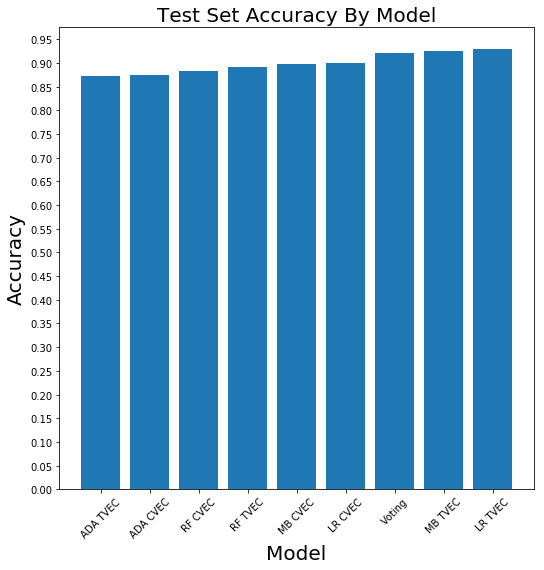

In [766]:
sorted_accs = metrics_df.sort_values(by = 'acc')

plt.figure(figsize=(8.5, 8.5))
plt.bar(sorted_accs.model,
        sorted_accs.acc)
plt.title('Test Set Accuracy By Model', fontsize = 20)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 1, step=0.05))
plt.xlabel("Model", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)




## Conclusion <a class="anchor" id="sixteen-bullet"></a>

After running our models, we now know which should be used in production.  The logistic regression model with TF-IDF performed best (highest accuracy) for our test dataset, getting 93% of posts correct.  This is higher than our baseline of 50%.  It is also higher than any of the other models we ran.  Using this model we will be able to answer our initial research question; predicting which sub-reddit a post belongs to using the post title.  

Although we have a model that will predict results correct for 93% of cases, additional research can performed.  We could attempt to use the hashing vectorizer to see if that improves our results.  As we learned by running both CVEC and TF-IDF, the vectorization does make a difference in the results of the models.  Running the models with the hashing vectorizer may improve results.  

We could also attempt to using the AdaBoost model with other models.  The decision tree was used as the base estimator, but other models could be attempted.  Additional research could also be performed on ensemble models.  These models could be high performing options.  The voting classifier model could also be modified to include other models, other than the top three performing options that we included.